In [14]:
# Import Libraries
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import matplotlib.pyplot as plt
from skimage.feature import hog, local_binary_pattern
from skimage.util import view_as_windows
import mahotas as mt

In [15]:
# Access the dataset folder
AllDatasetDirPath = r"C:\Users\Baryan\Desktop\dataset"
FolderList = my_list = os.listdir(AllDatasetDirPath)
print(FolderList)

['african_elephant', 'baboon', 'camel', 'horse', 'koala', 'opossum', 'sea_lion', 'sugar_glider', 'vicuna', 'yak']


In [16]:
# haralick

def create_dataset(dataset_dir):
    names = [f"haralick_{i+1}" for i in range(13)]
    names.append("classlabel")
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)

            # Convert the image to Grayscale
            gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)

            # Texture based features
            textures = mt.features.haralick(gray)
            ht_mean = list(textures.mean(axis=0))
            ht_mean.append(class_label)

            # Append the feature vector to the DataFrame
            df_temp = pd.DataFrame([ht_mean], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [17]:
dataset = create_dataset(AllDatasetDirPath)

Processing african_elephant:   0%|          | 0/347 [00:00<?, ?it/s]C:\Users\Baryan\AppData\Local\Temp\ipykernel_9744\1272111485.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dataset_results = pd.concat(
Processing yak: 100%|██████████| 254/254 [00:06<00:00, 38.86it/s]


In [18]:
dataset.shape

(2938, 14)

In [19]:
dataset.head()

,haralick_1,haralick_2,haralick_3,haralick_4,haralick_5,haralick_6,haralick_7,haralick_8,haralick_9,haralick_10,haralick_11,haralick_12,haralick_13,classlabel
0,0.002428,222.585912,0.947941,2137.135593,0.444445,261.574069,8325.956462,8.066720,11.083405,0.000667,3.818080,-0.450997,0.999033,0
1,0.000301,435.141796,0.894704,2066.598204,0.140828,157.452525,7831.251019,8.201341,12.934858,0.000166,5.105606,-0.215022,0.976219,0
2,0.000236,644.605509,0.872428,2526.592667,0.132950,240.707834,9461.765161,8.450350,13.382888,0.000135,5.421029,-0.212577,0.978347,0
3,0.000145,468.903820,0.904321,2450.295808,0.106789,174.321092,9332.279413,8.452185,13.417720,0.000138,5.300816,-0.208610,0.976296,0
4,0.000259,339.169305,0.946084,3145.700418,0.181900,189.061151,12243.632365,8.609554,12.697156,0.000254,4.465429,-0.335625,0.996716,0


In [20]:
dataset.to_csv("features/haralick_features.csv")

In [21]:
def overlay_features(image_path):
    # Read the image
    main_img = cv2.imread(image_path)
    original_img = main_img.copy()  # Create a copy for visualization

    # Preprocessing
    gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
    _, thresholded = cv2.threshold(
        gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU
    )
    contours, _ = cv2.findContours(
        thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    leaf_contour = max(contours, key=cv2.contourArea)

    # Extract features
    x, y, w, h = cv2.boundingRect(leaf_contour)
    area = cv2.contourArea(leaf_contour)
    perimeter = cv2.arcLength(leaf_contour, True)
    physiological_length = max(w, h)
    physiological_width = min(w, h)
    aspect_ratio = float(physiological_length) / physiological_width

    # Visualize the image with features overlay
    cv2.rectangle(
        original_img, (x, y), (x + w, y + h), (0, 255, 0), 2
    )  # Draw bounding box

    # Annotate extracted features
    text = (
        f"Area: {area:.2f}, Perimeter: {perimeter:.2f},Aspect Ratio: {aspect_ratio:.2f}"
    )
    cv2.putText(
        original_img,
        text,
        (0, y + 300),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.266,
        (0, 0, 0),
        1,
        cv2.LINE_AA,
    )

    # Display the image with annotations
    plt.figure(figsize=(10, 18))
    plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    plt.title("Image with Extracted Features Overlay")
    plt.axis("off")
    plt.show()

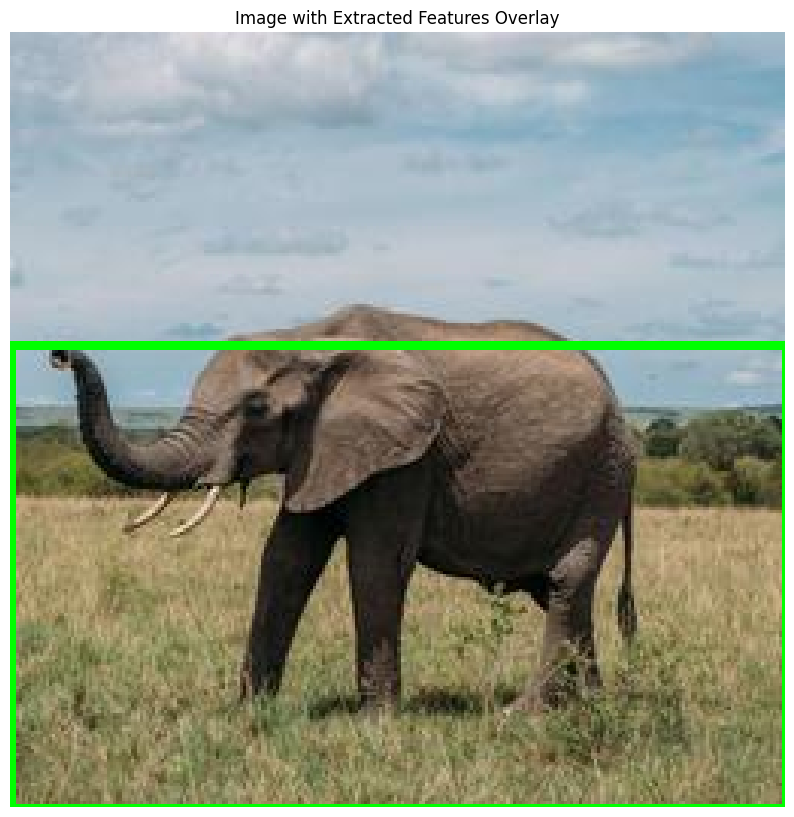

In [28]:
# Example usage
image_path = r"C:\Users\Baryan\Desktop\dataset\african_elephant\african_elephant-0006.jpg"  # Replace this with the path to your image file
overlay_features(image_path)

In [32]:
def calculate_features(gray):
    # Extract SIFT features
    gray = cv2.resize(gray, (100, 100))
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    sift_features = descriptors.flatten() if descriptors is not None else np.zeros(128)

    return sift_features


def create_dataset(dataset_dir):
    names = ["SIFT"]

    all_dataset_results = pd.DataFrame(columns=names)

    categories = next(os.walk(dataset_dir))[1]

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)

            # Convert the image to Grayscale
            gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)

            # Calculate features
            features = calculate_features(gray)

            # Append the feature vector to the DataFrame
            df_temp = pd.DataFrame([[features]], columns=names)
            df_temp["classlabel"] = class_label
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [33]:
dataset = create_dataset(AllDatasetDirPath)

Processing yak: 100%|██████████| 254/254 [00:01<00:00, 166.21it/s]


In [34]:
dataset.to_csv("features1.csv")

In [35]:
dataset.shape

(2938, 2)

In [36]:
dataset.head()

,SIFT,classlabel
0,"[7.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 20.0,...",0.0
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.0,...",0.0
2,"[4.0, 30.0, 36.0, 24.0, 5.0, 0.0, 0.0, 0.0, 0....",0.0
3,"[9.0, 43.0, 118.0, 116.0, 28.0, 0.0, 0.0, 0.0,...",0.0
4,"[5.0, 22.0, 33.0, 43.0, 30.0, 52.0, 18.0, 4.0,...",0.0


In [45]:
# run this hog
def create_dataset(dataset_dir):
    names = [f"hog_{i+1}" for i in range(7200)]
    names.append("classlabel")
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)
            main_img = cv2.resize(main_img, (100, 100))
            gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
            hog_features = hog(
                gray,
                orientations=8,
                pixels_per_cell=(8, 8),
                cells_per_block=(3, 3),
                visualize=False,
                block_norm="L2-Hys",
            )
            hog_features = list(hog_features)
            hog_features.append(class_label)
            # Append the feature vector to the DataFrame
            df_temp = pd.DataFrame([hog_features], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [46]:
dataset = create_dataset(AllDatasetDirPath)

Processing african_elephant:   0%|          | 0/347 [00:00<?, ?it/s]C:\Users\Baryan\AppData\Local\Temp\ipykernel_9744\3238389905.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dataset_results = pd.concat(
Processing yak: 100%|██████████| 254/254 [00:45<00:00,  5.57it/s]


In [47]:
dataset.shape

(2938, 7201)

In [48]:
dataset.head()

,hog_1,hog_2,hog_3,hog_4,hog_5,hog_6,hog_7,hog_8,hog_9,hog_10,...,hog_7192,hog_7193,hog_7194,hog_7195,hog_7196,hog_7197,hog_7198,hog_7199,hog_7200,classlabel
0,0.024510,0.000000,0.068672,0.031003,0.322914,0.035349,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.003053,0.000000,0.032946,0.014482,0.186729,0.017067,0.005572,0.000000,0
1,0.078046,0.079257,0.073847,0.048675,0.065820,0.046837,0.027445,0.046153,0.253453,0.040456,...,0.134634,0.039365,0.025615,0.034603,0.043379,0.034976,0.044742,0.040941,0.022257,0
2,0.184452,0.130220,0.111712,0.108045,0.137985,0.065481,0.105819,0.052519,0.165233,0.107977,...,0.072731,0.063721,0.176098,0.147452,0.138414,0.087969,0.179553,0.108735,0.062336,0
3,0.171934,0.029444,0.026929,0.074705,0.065993,0.104466,0.098631,0.121577,0.086259,0.023822,...,0.114418,0.052650,0.016040,0.083971,0.090188,0.050485,0.055571,0.070534,0.077241,0
4,0.107865,0.015995,0.022261,0.091138,0.088174,0.039579,0.052085,0.043244,0.185748,0.219022,...,0.028306,0.058173,0.024209,0.030815,0.014730,0.059866,0.021898,0.070056,0.023140,0


In [49]:
dataset.to_csv("features/hog_features.csv")

In [52]:
# run this 
def create_dataset(dataset_dir):
    names = [f"lbp_{i+1}" for i in range(10000)]
    names.append("classlabel")
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)
            main_img = cv2.resize(main_img, (100, 100))
            gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
            radius = 3
            n_points = 8 * radius
            lbp = local_binary_pattern(gray, n_points, radius, method="uniform")
            # Append the feature vector to the DataFrame
            lbp = list(lbp.flatten())
            lbp.append(class_label)
            df_temp = pd.DataFrame([lbp], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [53]:
dataset = create_dataset(AllDatasetDirPath)

Processing african_elephant:   0%|          | 0/347 [00:00<?, ?it/s]C:\Users\Baryan\AppData\Local\Temp\ipykernel_9744\3961121119.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_dataset_results = pd.concat(
Processing yak: 100%|██████████| 254/254 [01:09<00:00,  3.64it/s]


In [54]:
dataset.shape

(2938, 10001)

In [55]:
dataset.head()

,lbp_1,lbp_2,lbp_3,lbp_4,lbp_5,lbp_6,lbp_7,lbp_8,lbp_9,lbp_10,...,lbp_9992,lbp_9993,lbp_9994,lbp_9995,lbp_9996,lbp_9997,lbp_9998,lbp_9999,lbp_10000,classlabel
0,7.0,8.0,9.0,11.0,11.0,11.0,11.0,11.0,11.0,13.0,...,12.0,12.0,12.0,13.0,13.0,13.0,8.0,7.0,6.0,0
1,7.0,25.0,25.0,25.0,25.0,25.0,6.0,13.0,25.0,25.0,...,0.0,25.0,25.0,25.0,25.0,0.0,25.0,25.0,25.0,0
2,6.0,0.0,10.0,25.0,13.0,7.0,0.0,6.0,25.0,25.0,...,25.0,1.0,0.0,0.0,0.0,1.0,25.0,25.0,25.0,0
3,25.0,6.0,7.0,25.0,25.0,25.0,6.0,25.0,0.0,25.0,...,2.0,2.0,13.0,2.0,25.0,2.0,25.0,1.0,0.0,0
4,0.0,0.0,1.0,25.0,13.0,25.0,5.0,8.0,12.0,13.0,...,13.0,13.0,0.0,0.0,25.0,25.0,2.0,2.0,2.0,0


In [56]:
dataset.to_csv("features/lbp_features.csv")

In [57]:
# run this
def create_dataset(dataset_dir):
    names = [f"edge_{i+1}" for i in range(10000)]
    names.append("classlabel")
    all_dataset_results = pd.DataFrame(columns=names)

    for _, dirs, _ in os.walk(dataset_dir):
        if len(dirs) > 0:
            categories = dirs
            break

    for category in categories:
        category_path = os.path.join(dataset_dir, category)
        class_label = categories.index(category)
        for filename in tqdm(os.listdir(category_path), desc=f"Processing {category}"):
            imgpath = os.path.join(category_path, filename)
            main_img = cv2.imread(imgpath)
            main_img = cv2.resize(main_img, (100, 100))
            gray = cv2.cvtColor(main_img, cv2.COLOR_BGR2GRAY)
            edges = cv2.Canny(gray, 100, 200)
            edges = list(edges.flatten())
            edges.append(class_label)
            df_temp = pd.DataFrame([edges], columns=names)
            all_dataset_results = pd.concat(
                [all_dataset_results, df_temp], ignore_index=True
            )

    return all_dataset_results

In [58]:
dataset = create_dataset(AllDatasetDirPath)

Processing yak: 100%|██████████| 254/254 [01:32<00:00,  2.75it/s]


In [59]:
dataset.shape

(2938, 10001)

In [60]:
dataset.head()

,edge_1,edge_2,edge_3,edge_4,edge_5,edge_6,edge_7,edge_8,edge_9,edge_10,...,edge_9992,edge_9993,edge_9994,edge_9995,edge_9996,edge_9997,edge_9998,edge_9999,edge_10000,classlabel
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,255,0,0,0,0,255,0,255,0,0,...,0,0,0,0,255,255,255,255,0,0
3,0,0,0,0,0,0,0,0,0,0,...,255,255,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,255,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
dataset.to_csv("features/edges.csv")